# **Tanzanian water pumps project**

Data download: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/

In [1]:
#math stuff
import numpy as np
import scipy.stats as ss

#visualization
import pandas as pd
import seaborn as sns

#plotting maps on Jupyter

#plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Machine Learning
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

#debugginf
from IPython import embed

### Import Data

In [2]:
path = '/Users/andreacosta/Downloads/'  #modify this if needed
X_tr = pd.read_csv(path+'train_values.csv')
y_tr = pd.read_csv(path+'train_labels.csv')

X_tst = pd.read_csv(path+'test_values.csv')

#look at the data's shape
print('size train features: '+str(X_tr.shape[0])+', '+ str(X_tr.shape[1]))
print('size train labels: '+str(y_tr.shape[0])+', '+ str(y_tr.shape[1]))
print('size test features: '+str(X_tst.shape[0])+', '+ str(X_tst.shape[1]))

size train features: 59400, 40
size train labels: 59400, 2
size test features: 14850, 40


In [3]:
X_tr.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Divide features by type

In [4]:
#geographical
geog = ['gps_height','longitude','latitude','basin','subvillage','region','region_code','district_code','lga','ward']
print(X_tr[geog].head(5))
print('')
#sanity check
for col in geog:
    print(col, len(X_tr[col].unique()))

#time
dates = ['date_recorded', 'construction_year']
print(X_tr[dates].head(5))
print('')
#sanity check
for col in dates:
    print(col, len(X_tr[col].unique()))
    
#numerical
numerics = ['amount_tsh', 'population','num_private']
print(X_tr[numerics].head(5))
print('')
#sanity check
for col in numerics:
    print(col, len(X_tr[col].unique()))
    
#categorical
categories = [col for col in list(X_tr.columns) if not(col in geog) and not(col in dates) and not (col in numerics)]
categories.remove('id')
print(X_tr[categories].head(5))
print('')
#sanity check
for col in categories:
    print(col, len(X_tr[col].unique()))
##we see that 'recorded by' only has 1s. So erase it
categories.remove('recorded_by')
#Actual erasing done in the data cleaning below

#check that they are all
print('No. of categories = '+str(len(geog+dates+numerics+categories)))
print('')

   gps_height  longitude   latitude                    basin  subvillage  \
0        1390  34.938093  -9.856322               Lake Nyasa    Mnyusi B   
1        1399  34.698766  -2.147466            Lake Victoria     Nyamara   
2         686  37.460664  -3.821329                  Pangani     Majengo   
3         263  38.486161 -11.155298  Ruvuma / Southern Coast  Mahakamani   
4           0  31.130847  -1.825359            Lake Victoria  Kyanyamisa   

    region  region_code  district_code        lga        ward  
0   Iringa           11              5     Ludewa    Mundindi  
1     Mara           20              2  Serengeti       Natta  
2  Manyara           21              4  Simanjiro     Ngorika  
3   Mtwara           90             63   Nanyumbu    Nanyumbu  
4   Kagera           18              1    Karagwe  Nyakasimbi  

gps_height 2428
longitude 57516
latitude 57517
basin 9
subvillage 19288
region 21
region_code 27
district_code 20
lga 125
ward 2092
  date_recorded  construct

In [5]:
#display all labels and one value example
print(X_tr.loc[[0][0]])

id                                         69572
amount_tsh                                  6000
date_recorded                         2011-03-14
funder                                     Roman
gps_height                                  1390
installer                                  Roman
longitude                                34.9381
latitude                                -9.85632
wpt_name                                    none
num_private                                    0
basin                                 Lake Nyasa
subvillage                              Mnyusi B
region                                    Iringa
region_code                                   11
district_code                                  5
lga                                       Ludewa
ward                                    Mundindi
population                                   109
public_meeting                              True
recorded_by              GeoData Consultants Ltd
scheme_management   

## Data cleaning

In [6]:
#merge data in order to clean all of them
X = pd.concat([X_tr, X_tst])
print('Tot. No. of pumps: '+str(X.shape[0]))

##we saw that 'recorded by' only has 1s. So erase it
X = X.drop('recorded_by', axis=1)

Tot. No. of pumps: 74250


### Null data treatment

In [7]:
# Find columns with Null values and their number
nullcols = []
for col in X.columns:
    nmbnull = (X[col].isnull()*1).sum()
    if ( nmbnull > 0 ):
        tp = type(X[X[col].notnull()][col].iat[0]) # type of (first) non null value
        nullcols.append([col, tp])
        print(col, nmbnull, tp)

funder 4504 <class 'str'>
installer 4532 <class 'str'>
subvillage 470 <class 'str'>
public_meeting 4155 <class 'bool'>
scheme_management 4846 <class 'str'>
scheme_name 35258 <class 'str'>
permit 3793 <class 'bool'>


In [8]:
# Fill Null values in string columns with "MISSING"
for col, tp in nullcols:
    if (tp == type('abc')):
        X.loc[X[col].isnull(), col] = 'MISSING'
        
# For boolean (just a special case of category) : convert into string, then replace Null with "MISSING"
for col, tp in nullcols:
    if (tp == type(True)):
        X.loc[X[col]==True, col] = 'TRUE'
        X.loc[X[col]==False, col] = 'FALSE'
        X.loc[X[col].isnull(), col] = 'MISSING'

In [9]:
#check if it worked
X.isnull().any()

id                       False
amount_tsh               False
date_recorded            False
funder                   False
gps_height               False
installer                False
longitude                False
latitude                 False
wpt_name                 False
num_private              False
basin                    False
subvillage               False
region                   False
region_code              False
district_code            False
lga                      False
ward                     False
population               False
public_meeting           False
scheme_management        False
scheme_name              False
permit                   False
construction_year        False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_group            False
quantity

### Sanity check on geographical values

In [10]:
#Check frequency of most common values
for col in geog: 
    cs = X[col].value_counts(normalize=True, sort=True, ascending=False)
    for k in cs.keys()[0:5]:
        print( col, k, int(100*cs[k])/100 ) #rounding

gps_height 0 0.34
gps_height -16 0.0
gps_height -15 0.0
gps_height -13 0.0
gps_height -19 0.0
longitude 0.0 0.03
longitude 37.25011096 0.0
longitude 32.99609259 0.0
longitude 37.54157917 0.0
longitude 32.9936827 0.0
latitude -2e-08 0.03
latitude -6.98012199 0.0
latitude -6.98077879 0.0
latitude -2.46713695 0.0
latitude -6.9644683 0.0
basin Lake Victoria 0.17
basin Pangani 0.15
basin Rufiji 0.13
basin Internal 0.12
basin Lake Tanganyika 0.1
subvillage Shuleni 0.0
subvillage Majengo 0.0
subvillage Madukani 0.0
subvillage MISSING 0.0
subvillage Kati 0.0
region Iringa 0.08
region Shinyanga 0.08
region Mbeya 0.07
region Kilimanjaro 0.07
region Morogoro 0.06
region_code 11 0.08
region_code 17 0.08
region_code 12 0.07
region_code 3 0.07
region_code 5 0.06
district_code 1 0.2
district_code 2 0.18
district_code 3 0.16
district_code 4 0.15
district_code 5 0.07
lga Njombe 0.04
lga Moshi Rural 0.02
lga Arusha Rural 0.02
lga Bariadi 0.02
lga Rungwe 0.01
ward Igosi 0.0
ward Imalinyi 0.0
ward Siha Ka

In [11]:
#Substitute the 0s in gps_height with means gps_height
# at "basin"/"region"/"lga"/"ward" scale
bound_df = X[X['gps_height']>0]
print( bound_df.groupby(['basin',])['id'].count().min() ) # check enough data in each bucket

mean_geo_df = bound_df.groupby(['basin'])['gps_height'].mean()

assert(mean_geo_df.shape[0] == len(X['basin'].unique()))

mean_geo_df

1277


basin
Internal                   1476.981478
Lake Nyasa                 1521.101331
Lake Rukwa                 1410.216915
Lake Tanganyika            1269.110643
Lake Victoria              1328.311300
Pangani                    1102.570978
Rufiji                     1089.347315
Ruvuma / Southern Coast     455.507078
Wami / Ruvu                 310.433503
Name: gps_height, dtype: float64

In [12]:
# Before over-writing keep track of suspect rows with new binary columns
oldX=X
oldX['gps_height_orig'] = X['gps_height']<=0

# Modify
# Set "Basin" as the index.
v = X.set_index('basin')['gps_height']  
# Mask values that <= 0 and fill NaNs by the computed mean. 
X['gps_height'] = v.mask(v.le(0)).fillna(mean_geo_df).values

In [13]:
#check if it worked
for col in geog: 
    print(col)
    cs = X[col].value_counts(normalize=True, sort=True, ascending=False)
    for k in cs.keys()[0:5]:
        print( col, k, int(100*cs[k])/100 ) #rounding

gps_height
gps_height 1328.31129997 0.13
gps_height 1476.98147825 0.05
gps_height 1269.11064302 0.04
gps_height 1521.10133091 0.04
gps_height 310.433503335 0.03
longitude
longitude 0.0 0.03
longitude 37.25011096 0.0
longitude 32.99609259 0.0
longitude 37.54157917 0.0
longitude 32.9936827 0.0
latitude
latitude -2e-08 0.03
latitude -6.98012199 0.0
latitude -6.98077879 0.0
latitude -2.46713695 0.0
latitude -6.9644683 0.0
basin
basin Lake Victoria 0.17
basin Pangani 0.15
basin Rufiji 0.13
basin Internal 0.12
basin Lake Tanganyika 0.1
subvillage
subvillage Shuleni 0.0
subvillage Majengo 0.0
subvillage Madukani 0.0
subvillage MISSING 0.0
subvillage Kati 0.0
region
region Iringa 0.08
region Shinyanga 0.08
region Mbeya 0.07
region Kilimanjaro 0.07
region Morogoro 0.06
region_code
region_code 11 0.08
region_code 17 0.08
region_code 12 0.07
region_code 3 0.07
region_code 5 0.06
district_code
district_code 1 0.2
district_code 2 0.18
district_code 3 0.16
district_code 4 0.15
district_code 5 0.07
l

### Sanity check on time values

In [14]:
print(X['date_recorded'].head(5))
print('')

print(X['construction_year'].head(5))
print('')

for col in dates: # Check frequency of most common values
    cs = X[col].value_counts(normalize=True, sort=True, ascending=False)
    for k in cs.keys()[0:5]:
        print( col, k, int(cs[k]*10000)/100. ) #rounding

# WARNING : "construction_year" is 0 for one-third of the records

0    2011-03-14
1    2013-03-06
2    2013-02-25
3    2013-01-28
4    2011-07-13
Name: date_recorded, dtype: object

0    1999
1    2010
2    2009
3    1986
4       0
Name: construction_year, dtype: int64

date_recorded 2011-03-17 0.93
date_recorded 2011-03-15 0.93
date_recorded 2013-02-03 0.92
date_recorded 2011-03-16 0.87
date_recorded 2011-03-14 0.87
construction_year 0 34.97
construction_year 2010 4.46
construction_year 2008 4.36
construction_year 2009 4.3
construction_year 2000 3.47


In [15]:
#set zero values to mean epoch
oldX['construction_year_orig'] = X['construction_year'] #to keep track

#mean_year = int(np.round(X[X['construction_year']>0]['construction_year'].mean()))
#print(mean_year)

#X.loc[X['construction_year']==0, 'construction_year'] = mean_year

#or draw random date from available ones
X.loc[X['construction_year']==0, 'construction_year'] = \
np.random.choice(X.loc[X['construction_year']!=0, 'construction_year'], len(X.loc[X['construction_year']==0, 'construction_year']))

#check if it worked
cs = X['construction_year'].value_counts(normalize=True, sort=True, ascending=False)
for k in cs.keys()[0:5]:
    print( col, k, int(cs[k]*10000)/100. ) 

construction_year 2010 6.93
construction_year 2008 6.74
construction_year 2009 6.61
construction_year 2000 5.27
construction_year 2007 4.13


In [16]:
#tranform date to epoch  == pump age
oldX['date_recorded_orig'] = X['date_recorded'] #to keep track

X['date_recorded']=X['date_recorded'].apply(lambda x: \
    int(( int(x.split('-')[0])+int(x.split('-')[1])/12+int(x.split('-')[2])/365)*10000 )/10000)
print(X['date_recorded'].head(5))

X['construction_year']=X['construction_year'].apply(lambda x: 2018-x) #pump age
print(X['construction_year'].head(5))

0    2011.2883
1    2013.2664
2    2013.2351
3    2013.1600
4    2011.6189
Name: date_recorded, dtype: float64
0    19
1     8
2     9
3    32
4    34
Name: construction_year, dtype: int64


### Convert string values to numbers

In [17]:
categorical = [col for col in list(X.columns) if not(col in geog) and not(col in dates) and not (col in numerics)]
print(categorical)

for col in categorical:
    cs = X[col].value_counts(normalize=False, sort=True, ascending=False)
    rare_values = [k for k in cs.keys() if cs[k]<40]
    if len(rare_values)>0:
        print( 'Trim values : ', col, len(rare_values))
        X.loc[X[col].isin(rare_values), col] = col+'_rare'


['id', 'funder', 'installer', 'wpt_name', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'gps_height_orig', 'construction_year_orig', 'date_recorded_orig']
Trim values :  id 74250
Trim values :  funder 1945
Trim values :  installer 2223
Trim values :  wpt_name 45618
Trim values :  scheme_management 1
Trim values :  scheme_name 2692
Trim values :  extraction_type 1
Trim values :  water_quality 1
Trim values :  waterpoint_type 1
Trim values :  waterpoint_type_group 1
Trim values :  construction_year_orig 4
Trim values :  date_recorded_orig 113


In [18]:
##we also drop the id

X = X.drop('id', axis=1)

In [19]:
#print('nan = '+str(X.isnull().sum().sum()))  #debugging

#label encoding
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse=False, dtype=int)
X = vec.fit_transform(X.to_dict(orient='record'))
#for col in categorical:
    #print(type(X[col])) #debug
#    X[col] = vec.fit_transform(X[col])

In [20]:
#also convert remaining string values
#for col in list(X.columns):
#    if X[col].dtype != np.number: 
#        X[col] = vec.fit_transform(X[col])

In [21]:
# check if it worked
#X.applymap(type).eq(str).any()
np.isnan(X).any()

False

In [22]:
X.shape

(74250, 24725)

### Look at the labels

In [23]:
print(y_tr.head(5))
#check how many different labels
print(y_tr['status_group'].unique())
status = ['non functional', 'functional needs repair', 'functional']
print(status)
#==> 3 labels: functional / not func / needs repair

      id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional
['functional' 'non functional' 'functional needs repair']
['non functional', 'functional needs repair', 'functional']


In [24]:
#transform in numerical values (3 classes)
catenc = pd.factorize(y_tr['status_group'])   #how to force functional=2,non fun=0, need rep=1?
y_tr['label'] = catenc[0]

In [25]:
y_tr[15:25]

,id,status_group,label
15,61848,functional,0
16,48451,non functional,1
17,58155,non functional,1
18,34169,functional needs repair,2
19,18274,functional,0
20,48375,functional,0
21,6091,functional,0
22,58500,functional needs repair,2
23,37862,functional,0
24,51058,functional,0


### Re-separate data

In [26]:
X_tr = X[:X_tr.shape[0]]
X_tst = X[X_tr.shape[0]:]

In [27]:
print('size train features: '+str(X_tr.shape[0])+', '+ str(X_tr.shape[1]))
print('size test features: '+str(X_tst.shape[0])+', '+ str(X_tst.shape[1]))

size train features: 59400, 24725
size test features: 14850, 24725


### Simple Statistics

In [28]:
#X_tr.describe()

### Normalize data

In [29]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_tr_norm = pd.DataFrame(mms.fit_transform(X_tr))
X_tst_norm = pd.DataFrame(mms.transform(X_tst))

/Users/andreacosta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Now the fun part!

## Shuffle

In [30]:
#Shuffle in case initial order was not random
#X_tr_norm = X_tr_norm.sample(frac=1)
#X_tst_norm = X_tst_norm.sample(frac=1)

print(X_tr_norm.shape[0])
print(X_tr_norm.shape[1])

print(X_tst_norm.shape[0])
print(X_tst_norm.shape[1])

59400
24725
14850
24725


### Dimensionality reduction

(59400, 2)


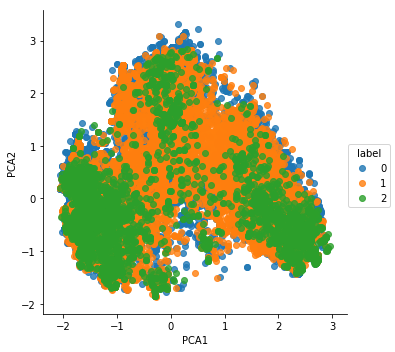

In [31]:
#PCA (just for visualization now)
#retain two dimensions 
from sklearn.decomposition import PCA
model = PCA(n_components=2)
model.fit(X_tr_norm)
X_tr_norm_2D = model.transform(X_tr_norm)
print(X_tr_norm_2D.shape)

d = {'label': y_tr['label']}
Xred = pd.DataFrame(data=d)

Xred['PCA1'] = X_tr_norm_2D[:, 0]
Xred['PCA2'] = X_tr_norm_2D[:, 1]

f = sns.lmplot("PCA1","PCA2",hue='label',data = Xred, fit_reg=False)
f.fig
#savefig('PCA2.png')

(59400, 3)


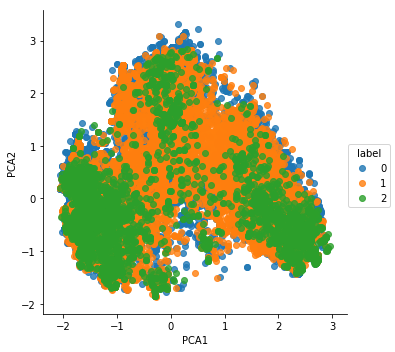

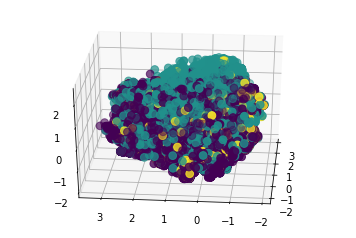

In [32]:
model = PCA(n_components=3)
model.fit(X_tr_norm)
X_tr_norm_3D = model.transform(X_tr_norm)
print(X_tr_norm_3D.shape)

d = {'label': y_tr['label']}
Xred = pd.DataFrame(data=d)

Xred['PCA1'] = X_tr_norm_3D[:, 0]
Xred['PCA2'] = X_tr_norm_3D[:, 1]
Xred['PCA3'] = X_tr_norm_3D[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xred['PCA1'], Xred['PCA2'], Xred['PCA3'], c=Xred['label'], s=60)
ax.view_init(30, 185)
plt.show()
#savefig('PCA3.png')

In [ ]:
#use PCA to determine number of components to retain
pca = PCA(n_components=150).fit(X_tr_norm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## SVM

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='linear',C=0.1) #how to choose C with not too much effort?
model.fit(X_tr_norm,y_tr['label'])
y_pred = model.predict(X_tr_norm)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_tr['label'],y_pred))

In [ ]:
#Use PCA to reduce dimensionality
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=???, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_tr_norm, y_tr,
                                                random_state=42)

from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

#performance
model = grid.best_estimator_
yfit = model.predict(Xtest)
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

#confusion matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_tr_norm,y_tr['label'])
y_pred = model.predict(X_tr_norm)

print(classification_report(y_tr['label'],y_pred))

## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_tr_norm,y_tr['label'])
y_pred = model.predict(X_tr_norm)

print(classification_report(y_tr['label'],y_pred))

## Logistic regression

## Random Forest

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier #ensamble 

RFC = DecisionTreeClassifier()
bag = BaggingClassifier(RFC, n_estimators=100, max_samples=0.8,
                        random_state=1)
#training
bag.fit(X_tr_norm, y_tr['label'])

#prediction
y_pred = model.predict(X_tr_norm)

#performance
from sklearn import metrics

print(metrics.classification_report(y_pred, y_tr['label']))

## XGBoost